# IMPORTS

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, f_oneway, levene, mannwhitneyu
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
%matplotlib inline

## Import game data into dataframes

In [2]:
df_no=pd.read_csv("../data/no_rem.csv",sep=";",index_col="game_number")
df_no.head(3)

,start,kill_turn,actions
game_number,,,
1,On the draw!,6.0,['3 Lands in hand(\n [\'Flooded...
2,On the draw!,6.0,['2 Lands in hand(\n [\'Island\...
3,On the play!,12.0,"[""3 Lands in hand(\n ['Watery G..."


In [3]:
df_half=pd.read_csv("../data/half_rem.csv",sep=";",index_col="game_number")
df_half.head(3)

,start,kill_turn,actions
game_number,,,
1,On the draw!,7.0,"[""3 Lands in hand(\n ['Poll..."
2,On the draw!,6.0,['3 Lands in hand(\n [\'Watery ...
3,On the draw!,6.0,['3 Lands in hand(\n [\'Island\...


In [4]:
df_full=pd.read_csv("../data//full_rem.csv",sep=";",index_col="game_number")
df_full.head(3)

,start,kill_turn,actions
game_number,,,
1,On the play!,5.0,"[""3 Lands in hand(\n ['Island',..."
2,On the draw!,11.0,['2 Lands in hand(\n [\'Pol...
3,On the draw!,5.0,['3 Lands in hand(\n [\'Island\...


# Preprocessing

## Improving the categories for analysis

In [5]:
def pre_process_df(df:pd.DataFrame, removal_priority:float)->pd.DataFrame:
    """Adds "on_play" and "on_draw" columns to the dataframe with 1 or 0 for
    respectivelly True and False, adds a column for the removal priority of the
    simulation as a float.
    Parameters:
        df: pd.DataFrame
        removal_priority: float

    Returns:
        df: pd.DataFrame
        """
    df["on_play"] = df["start"].str.contains("On the play!").astype(int)
    df["on_draw"] = df["start"].str.contains("On the draw!").astype(int)
    df["removal_priority"] = removal_priority
    return df

In [6]:
df_no=pre_process_df(df_no,0)
df_half=pre_process_df(df_half,0.5)
df_full=pre_process_df(df_full,1)

## Merging DataFrames and changing index of the result

In [7]:
df_all=pd.concat([df_no,df_half,df_full], ignore_index=True)
df_all.head(3)

,start,kill_turn,actions,on_play,on_draw,removal_priority
0,On the draw!,6.0,['3 Lands in hand(\n [\'Flooded...,0,1,0.0
1,On the draw!,6.0,['2 Lands in hand(\n [\'Island\...,0,1,0.0
2,On the play!,12.0,"[""3 Lands in hand(\n ['Watery G...",1,0,0.0


# Exploratory Data Analysis(EDA)

As per the simulation, the mulligan function doesn't check the card quality by its priority, only checks for lands and nonlands by cards in hand after mulligan and forces a game forfeit for 4+ mulligans. 

This means the game forfeit should be distributed approximately evenly with the removal priority and play/draw, but also means there are some bad hands that were kept that would not be kept in a real game, for example, starting the game with 2 colourless lands in hand and now drawing a coloured mana fast enough, which massively hinders gameplay. Those scenarios are the extremes of the high kill_turn count.

### Checking for forfeit based on removal prio, and play/draw as a sanity check for the simulation results

In [8]:
df_all["kill_turn"] = pd.to_numeric(df_all["kill_turn"], errors="coerce")
df_all["forfeit"] = df_all["kill_turn"].isna().astype(int)
forfeit_summary = (
    df_all.groupby(["removal_priority", "on_play"])
    .agg(
        total_games=("forfeit", "count"),
        forfeits=("forfeit", "sum")
    )
    .assign(forfeit_rate=lambda x: x["forfeits"] / x["total_games"])
    .reset_index()
)
print(f"Percentage of forfit games overall: {df_all["forfeit"].sum()*100/df_all.shape[0]:.2f}%")
forfeit_summary

Percentage of forfit games overall: 0.93%


,removal_priority,on_play,total_games,forfeits,forfeit_rate
0,0.0,0,50056,465,0.009290
1,0.0,1,49944,497,0.009951
2,0.5,0,49828,450,0.009031
3,0.5,1,50172,439,0.008750
4,1.0,0,49994,477,0.009541
5,1.0,1,50006,461,0.009219


Forfeit rates are under 1% and seem to be fairly consistent throughout the sim parameter and play/draw condition!

In [9]:
df_all_forfits_removed=df_all.dropna()
df_all_forfits_removed=df_all_forfits_removed.drop(columns="forfeit")
df_all_forfits_removed.reset_index(drop=True)
df_all_forfits_removed.head(3)

,start,kill_turn,actions,on_play,on_draw,removal_priority
0,On the draw!,6.0,['3 Lands in hand(\n [\'Flooded...,0,1,0.0
1,On the draw!,6.0,['2 Lands in hand(\n [\'Island\...,0,1,0.0
2,On the play!,12.0,"[""3 Lands in hand(\n ['Watery G...",1,0,0.0


### Checking for high kill turn extremes that indicate keeping "bricked" hands.

These are irrelevant for the analysis because they would result in a loss given the opponents deck would outpace ours always.

In [10]:
my_pal = {"On Play": "skyblue", "On Draw": "grey"}
df_all_forfits_removed["start_label"] = np.where(df_all_forfits_removed["on_play"]==1, "On Play", "On Draw")

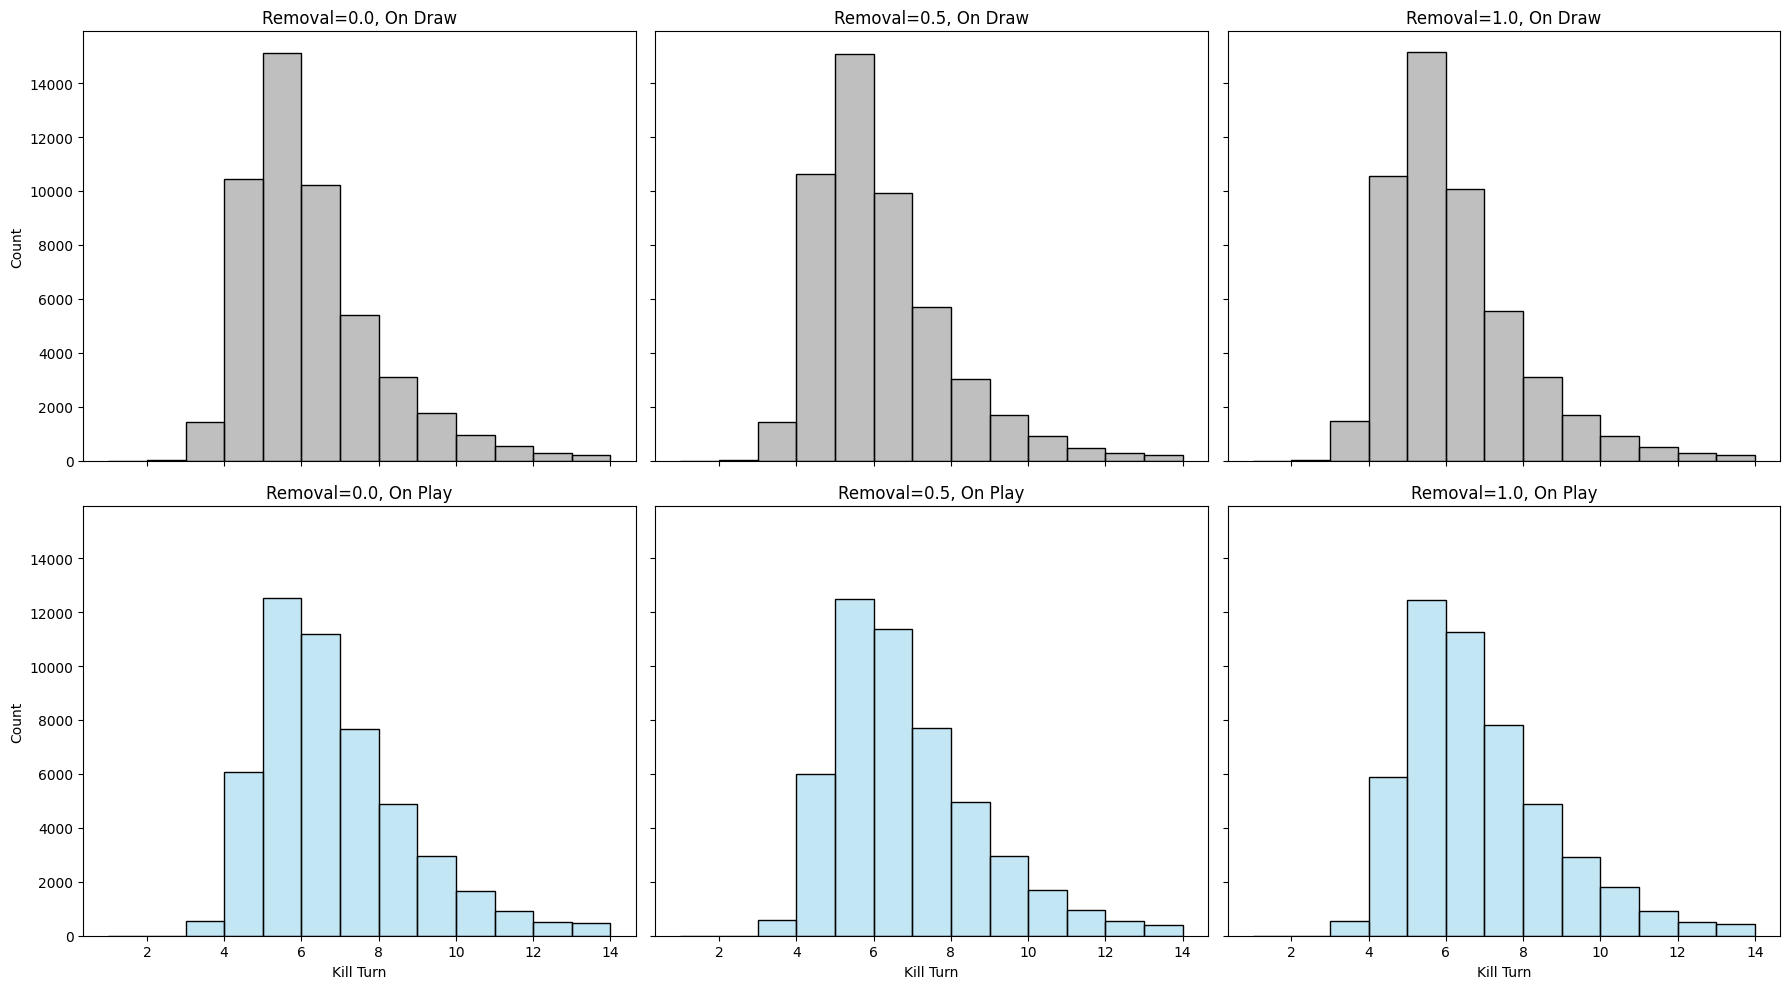

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
removal_levels = sorted(df_all_forfits_removed["removal_priority"].unique())
play_levels = [0, 1]
for i, rp in enumerate(removal_levels):
    for j, op in enumerate(play_levels):
        ax = axes[j, i]
        subset = df_all_forfits_removed[(df_all_forfits_removed["removal_priority"] == rp) & (df_all_forfits_removed["on_play"] == op)]
        sns.histplot(
    data=subset,
    x="kill_turn",
    bins=range(1, 15),
    hue="start_label",
    hue_order=["On Draw", "On Play"],
    kde=False,
    ax=ax,
    palette=my_pal,
    legend=False

)

        ax.set_title(f"Removal={rp}, {'On Play' if op==1 else 'On Draw'}")
        ax.set_xlabel("Kill Turn")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

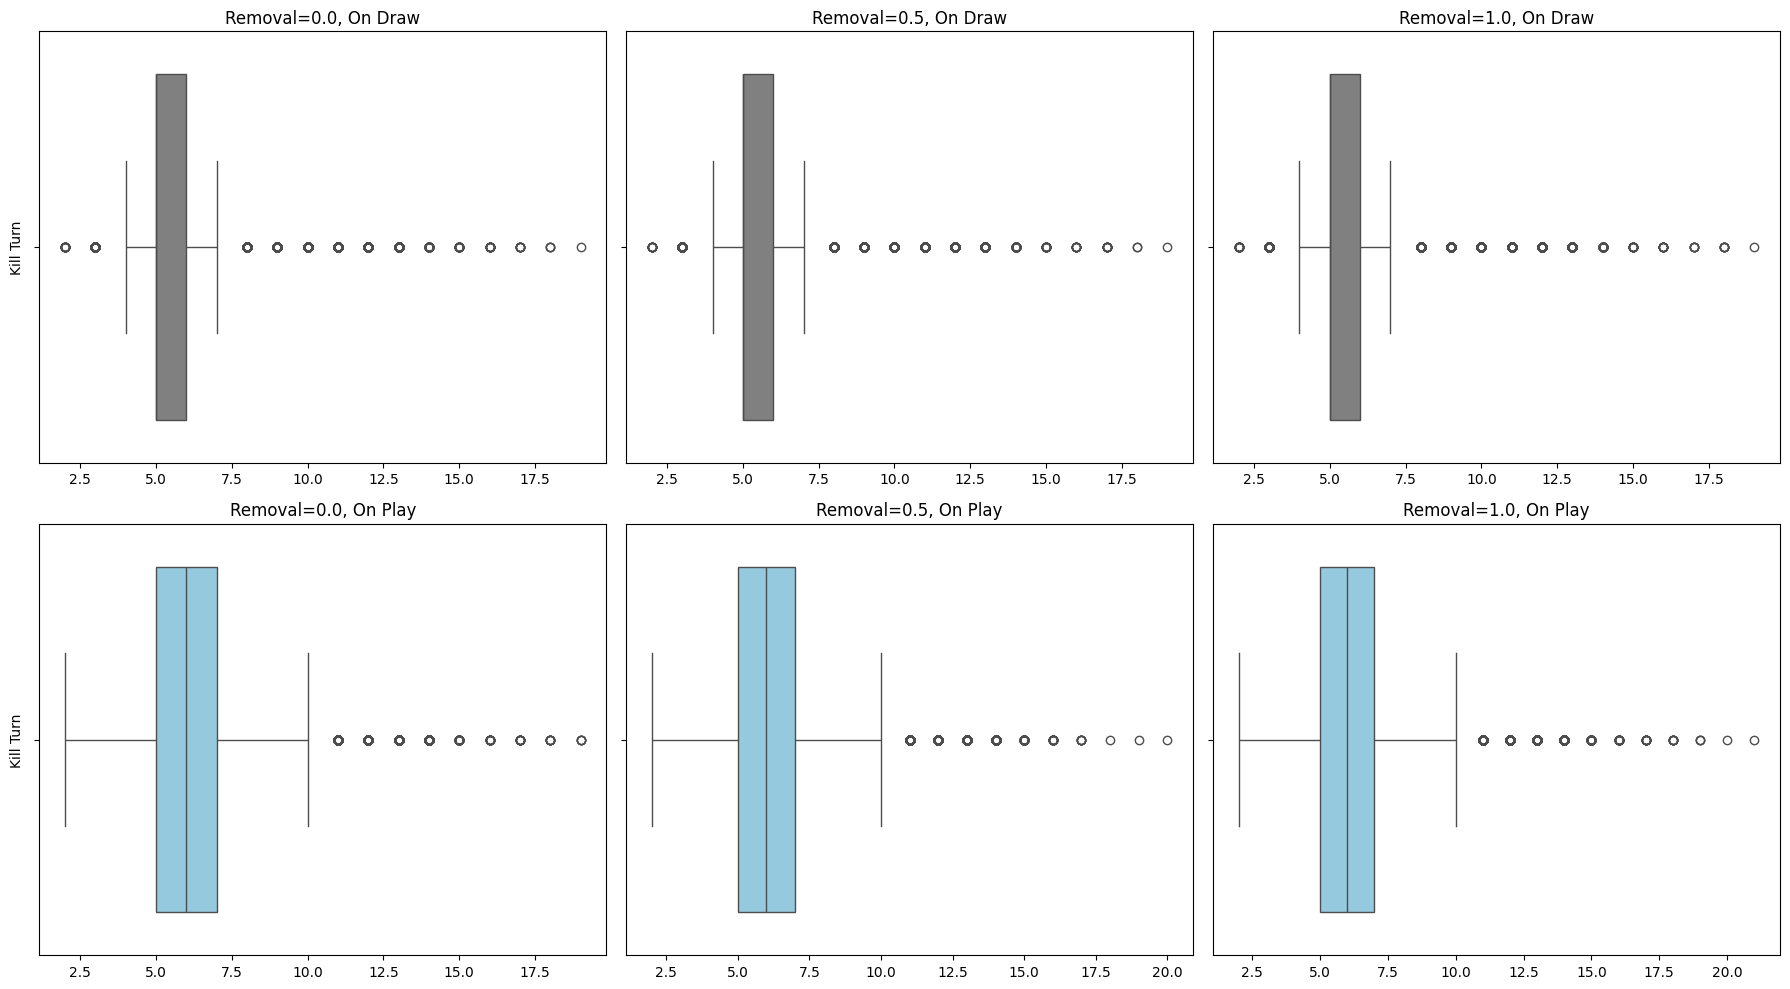

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
for i, rp in enumerate(removal_levels):
    for j, op in enumerate(play_levels):
        ax = axes[j, i]
        subset = df_all_forfits_removed[(df_all_forfits_removed["removal_priority"] == rp) & (df_all_forfits_removed["on_play"] == op)]
        sns.boxplot(data=subset,x="kill_turn", ax=ax,hue="start_label",hue_order=["On Draw", "On Play"],palette=my_pal,legend=False)

        ax.set_title(f"Removal={rp}, {'On Play' if op==1 else 'On Draw'}")
        ax.set_xlabel("")
        ax.set_ylabel("Kill Turn")

plt.tight_layout()
plt.show()

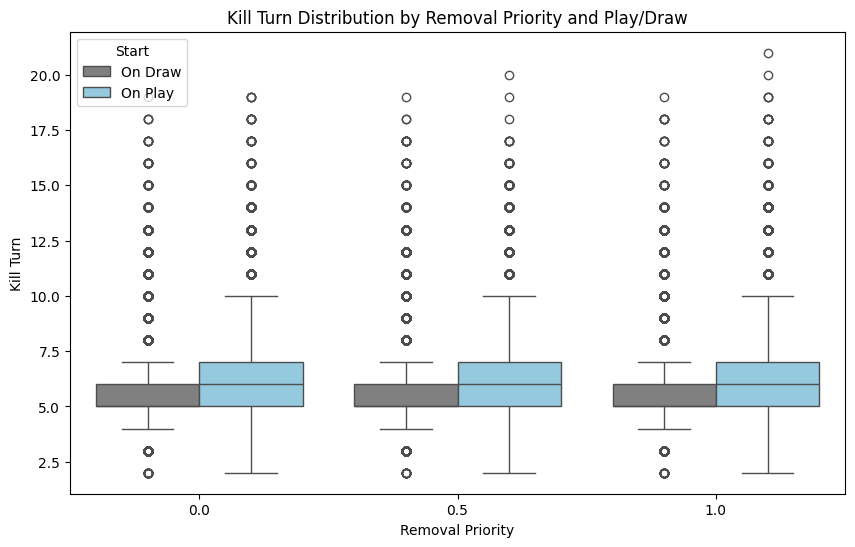

In [13]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=df_all_forfits_removed,
    x="removal_priority",
    y="kill_turn",
    hue="start_label",
    order=[0.0, 0.5, 1.0],
    hue_order=["On Draw", "On Play"],
    palette=my_pal
)
ax.set_title("Kill Turn Distribution by Removal Priority and Play/Draw")
ax.set_xlabel("Removal Priority")
ax.set_ylabel("Kill Turn")
ax.legend(title="Start")
plt.show()

### First Statistical Description

In [14]:
grouped = df_all_forfits_removed.groupby(['start_label', 'removal_priority'])
stats = grouped['kill_turn'].agg(['mean', 'std', skew, kurtosis])
stats.columns = ['mean', 'std', 'skewness', 'kurtosis']
print(stats)

                                  mean       std  skewness  kurtosis
start_label removal_priority                                        
On Draw     0.0               5.732492  1.773112  1.411139  3.024149
            0.5               5.713800  1.755952  1.421562  3.149422
            1.0               5.708787  1.748649  1.392674  3.013962
On Play     0.0               6.373005  1.962117  1.190384  2.023177
            0.5               6.378622  1.950199  1.137687  1.744975
            1.0               6.398870  1.971138  1.208410  2.170146


### Observations

We have outliers in most modes. From a player/game pattern perspective we evaluate the following from these plots:

  -While on the play, early turn kills aren't considered outliers (outside the whiskers). Since the opponent commonly loses on their turn in the draw step for not being able to draw, on the play a turn 3 kill, for example, would mean we had our turn 3 and the opponent lost on his turn 3. On the draw, a turn 3 kill would mean we had our turn 2 and the opponent lost on the following turn as well. Our turns available to play which correspond to mana available to play, are the main barrier for early turn kills, the extra draw step we have doesn't have the same relevance. This makes kills on the play in early turns appear statistically more significant than on the draw.

-While on the draw, late turn kills become less likely since we start on average (extra draw step but still mulligan) with an extra card in hand, which makes it less likely for a hand to "brick"(term associated with having a hand that can't do much, usually by lack of mana of specific colour, repeated draws of low impact cards, "mana flood" or "mana screwed").

-Giving removal a higher priority doesn't visually seem to impact early turn kills given the tight nature of the possible card possibility amounts to achieve them, known as "The nuts"(the best combination of cards in a particular hand, usually employed in poker, but also used in Magic the Gathering to mean the best hands a certain deck can give), but seems to have an impact on higher turns, given that prioritizing removal cards to effective mill cards consumes turns to handle opponent "board presence"(amount of dangerous cards on the opponent's board, usually creatures) disregarding advancing the player's main win condition of milling out the opponent.

### Removing outliers for statistical purposes

For statistical analysis purposes, we will remove the outliers from each mode, but store seperately the outliers for early turn kills since these indicate where "The nuts" occurred, therefore, they are significant for a player recognizing "The nuts" in games.

In [15]:
grouped = df_all_forfits_removed.groupby(['start_label', 'removal_priority'])
cleaned_data = pd.DataFrame()
low_kill_outliers = pd.DataFrame()

for (play_draw, priority), group in grouped:
    Q1 = group['kill_turn'].quantile(0.25)
    Q3 = group['kill_turn'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    cleaned_group = group[group['kill_turn'] <= upper_bound]

    low_outliers_group = group[group['kill_turn'] < lower_bound]

    cleaned_data = pd.concat([cleaned_data, cleaned_group])
    low_kill_outliers = pd.concat([low_kill_outliers, low_outliers_group])
cleaned_data.reset_index(drop=True,inplace=True)
cleaned_data.to_csv('../data/cleaned_mill_data.csv', index=False)
low_kill_outliers.to_csv('../data/low_kill_outliers.csv', index=False)
print(f"Cleaned data shape: {cleaned_data.shape}")
print(f"Low kill-turn outliers shape: {low_kill_outliers.shape}")

Cleaned data shape: (271057, 7)
Low kill-turn outliers shape: (4407, 7)


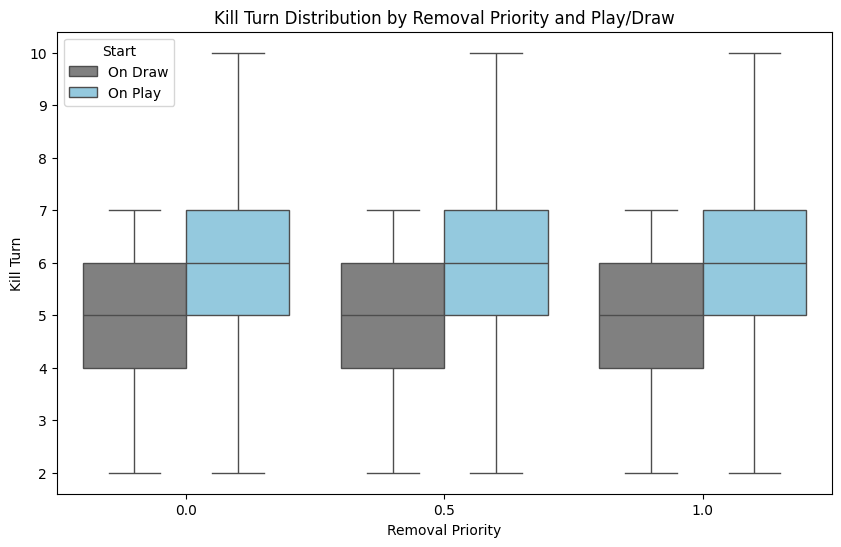

In [16]:
cleaned_data["start_label"] = np.where(cleaned_data["on_play"]==1, "On Play", "On Draw")
my_pal = {"On Play": "skyblue", "On Draw": "grey"}
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=cleaned_data,
    x="removal_priority",
    y="kill_turn",
    hue="start_label",
    order=[0.0, 0.5, 1.0],
    hue_order=["On Draw", "On Play"],
    palette=my_pal
)
ax.set_title("Kill Turn Distribution by Removal Priority and Play/Draw")
ax.set_xlabel("Removal Priority")
ax.set_ylabel("Kill Turn")
ax.legend(title="Start")
plt.show()

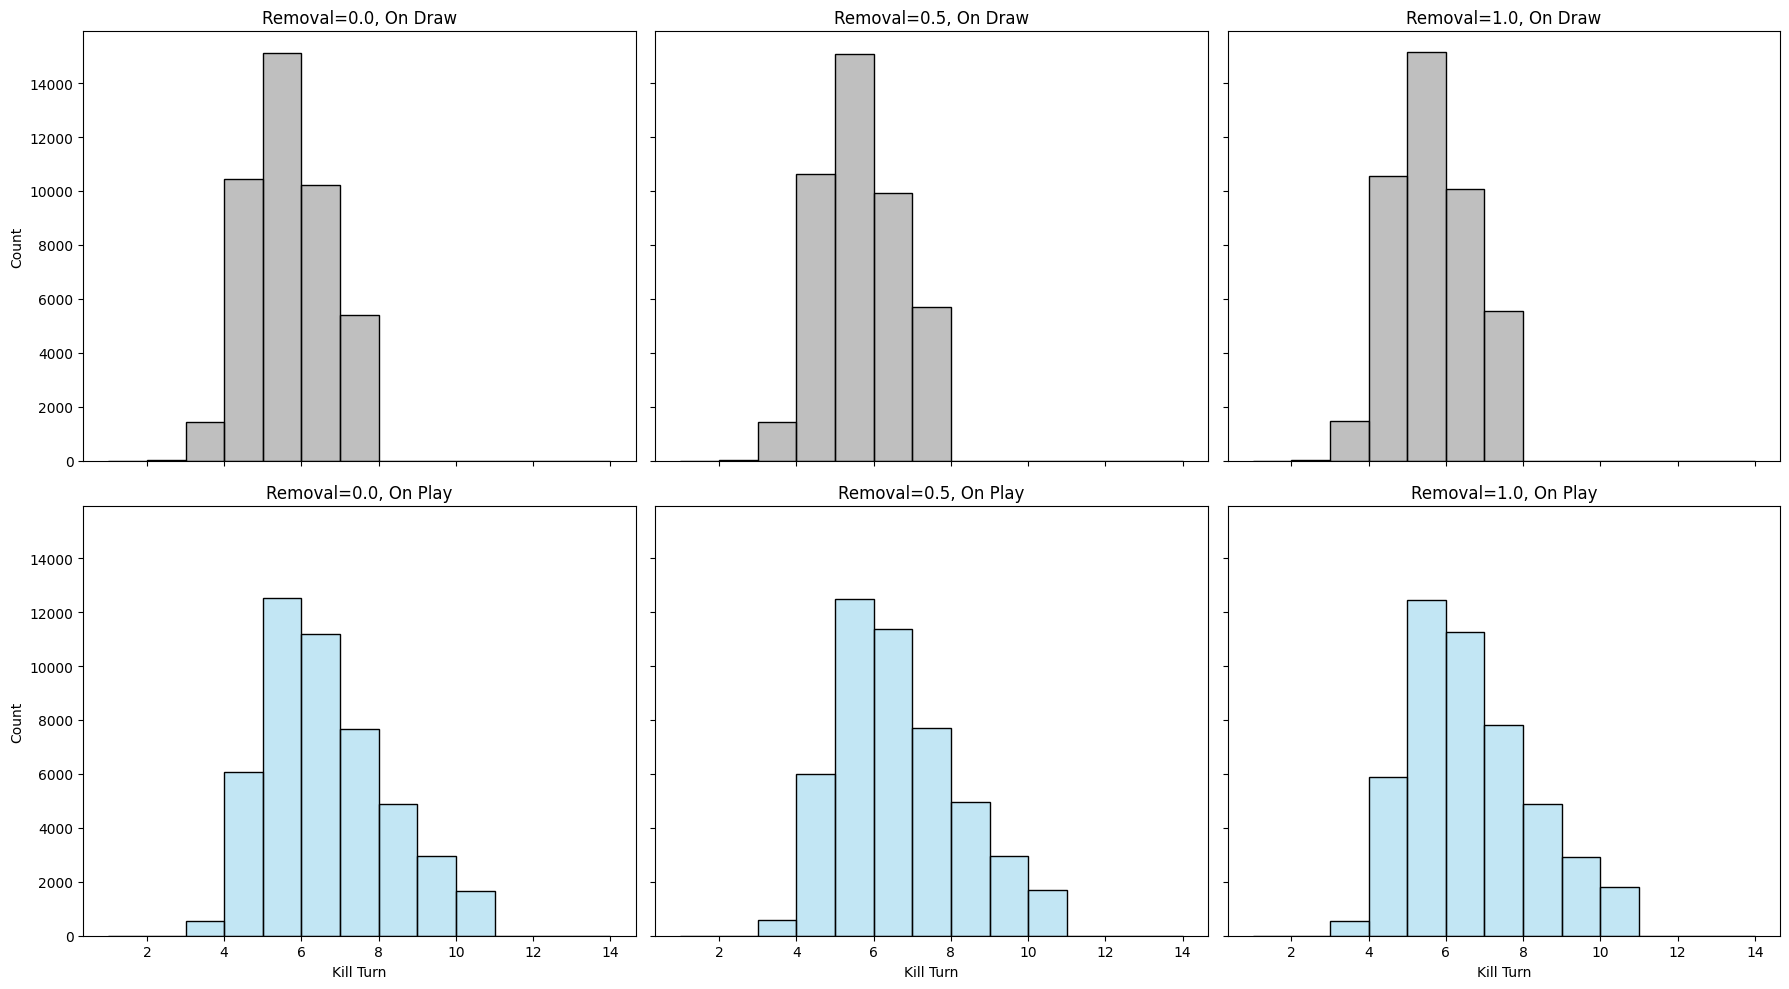

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
removal_levels = sorted(cleaned_data["removal_priority"].unique())
play_levels = [0, 1]
for i, rp in enumerate(removal_levels):
    for j, op in enumerate(play_levels):
        ax = axes[j, i]
        subset = cleaned_data[(cleaned_data["removal_priority"] == rp) & (cleaned_data["on_play"] == op)]
        sns.histplot(data=subset,x="kill_turn",bins=range(1, 15),hue="start_label",
                     hue_order=["On Draw", "On Play"], kde=False,ax=ax,palette=my_pal,legend=False)

        ax.set_title(f"Removal={rp}, {'On Play' if op==1 else 'On Draw'}")
        ax.set_xlabel("Kill Turn")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

The data is now without outliers. There seems to be some slight visual differences in mean, standard deviation, skewness and kurtosis. 
Calculating these for each mode.

### Second Statistical Description

In [18]:
grouped = cleaned_data.groupby(['start_label', 'removal_priority'])
stats = grouped['kill_turn'].agg(['mean', 'std', skew, kurtosis])
stats.columns = ['mean', 'std', 'skewness', 'kurtosis']
print(stats)

                                  mean       std  skewness  kurtosis
start_label removal_priority                                        
On Draw     0.0               5.179088  1.048818  0.110144 -0.685938
            0.5               5.182361  1.056422  0.133746 -0.728827
            1.0               5.177038  1.054261  0.118200 -0.699766
On Play     0.0               6.138919  1.597878  0.548820 -0.308029
            0.5               6.146732  1.597630  0.540085 -0.304332
            1.0               6.162424  1.601695  0.546672 -0.299571


# Hipothesis Testing

## Statistical significance of differences in Mean and Standart Deviation

ANOVA will be used changing removal priority since it's not a binary choice for Mean

### ANOVA on the play(changing removal priority)

In [19]:
on_play_groups = [
    cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == p)]['kill_turn']
    for p in cleaned_data['removal_priority'].unique()]
f_stat, p_value = f_oneway(*on_play_groups)
print(f"ANOVA p-value: {p_value:.4f}")

ANOVA p-value: 0.0697


Leven's test will be used for differences in standard deviation

### Leven's test on the play

In [20]:
stat, p_value = levene(*on_play_groups)
print(f"Levene's p-value: {p_value:.4f}")

Levene's p-value: 0.8895


### ANOVA on the draw(changing removal priority)

In [21]:
on_play_groups = [
    cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == p)]['kill_turn']
    for p in cleaned_data['removal_priority'].unique()]
f_stat, p_value = f_oneway(*on_play_groups)
print(f"ANOVA p-value: {p_value:.4f}")

ANOVA p-value: 0.7573


### Leven's test on the draw

In [22]:
stat, p_value = levene(*on_play_groups)
print(f"Levene's p-value: {p_value:.4f}")

Levene's p-value: 0.3051


Between priority removals, keeping Play/Draw constant, there isn't a statistical significance between Mean or Standard Deviation 

### Leven's test keeping removal priority constant with changing Play/Draw condition

In [23]:
for priority in cleaned_data['removal_priority'].unique():
    play_data = cleaned_data[(cleaned_data['start_label'] == 'On Play') &
                            (cleaned_data['removal_priority'] == priority)]['kill_turn']
    draw_data = cleaned_data[(cleaned_data['start_label'] == 'On Draw') &
                            (cleaned_data['removal_priority'] == priority)]['kill_turn']

    stat, p_value = levene(play_data, draw_data)
    variance_ratio = play_data.var() / draw_data.var()

    print(f"Priority {priority}:")
    print(f"  Levene's p-value = {p_value:.6f}")
    print(f"  Variance ratio (Play/Draw) = {variance_ratio:.2f}")
    print("---")

Priority 0.0:
  Levene's p-value = 0.000000
  Variance ratio (Play/Draw) = 2.32
---
Priority 0.5:
  Levene's p-value = 0.000000
  Variance ratio (Play/Draw) = 2.29
---
Priority 1.0:
  Levene's p-value = 0.000000
  Variance ratio (Play/Draw) = 2.31
---


As we can see from the statistics table and the Levene's test, there is a clear difference in standard deviation between play/draw conditions, instead of using a t-test, we'll use a non-parametric alternative, the Mann-Whitney U test which is variance agnostic.

### Mann-Whitney U test on fixed priority(changing play/draw) with Rank-Biserial Correlation(RBC) to account for magnitude size

In [24]:
def rank_biserial(group1, group2):
    n1, n2 = len(group1), len(group2)
    u = mannwhitneyu(group1, group2).statistic
    return 1 - (2 * u) / (n1 * n2)

for priority in cleaned_data['removal_priority'].unique():
    play_data = cleaned_data[(cleaned_data['start_label'] == 'On Play') &
                            (cleaned_data['removal_priority'] == priority)]['kill_turn']
    draw_data = cleaned_data[(cleaned_data['start_label'] == 'On Draw') &
                            (cleaned_data['removal_priority'] == priority)]['kill_turn']


    u_stat, p_value = mannwhitneyu(play_data, draw_data, alternative='two-sided')

    rbc = rank_biserial(play_data, draw_data)

    print(f"Priority {priority}:")
    print(f"  p-value = {p_value:.3f}")
    print(f"  Rank-biserial = {rbc:.3f}")
    print("---")

Priority 0.0:
  p-value = 0.000
  Rank-biserial = -0.338
---
Priority 0.5:
  p-value = 0.000
  Rank-biserial = -0.341
---
Priority 1.0:
  p-value = 0.000
  Rank-biserial = -0.348
---


### Conclusions for Mean and Standart Deviation

There is a significant statistical difference for Mean and Standard Deviation on kill turn on the draw vs on the play, even when analysing for constant removal_priorities, but there isn't a significant statistical difference on the Mean and Standard Deviation on kill turn when changing the removal priority and keeping on the draw/play constant.

## Statistical significance of differences in Skewedness and Kurtosis

### Bootstraping to check for skewedness and kurtosis between Play/Draw

In [25]:
def bootstrap_ci(data, func, n_boot=1000):
    boots = [func(np.random.choice(data, len(data))) for _ in range(n_boot)]
    return np.percentile(boots, [2.5, 97.5])

### Skewedness for Play/Draw with no removal priority

In [26]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 0)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 0)]['kill_turn']

ci1 = bootstrap_ci(group1, skew)
ci2 = bootstrap_ci(group2, skew)
print(f"Skewness CI - On Play: {ci1}, On Draw: {ci2}")

Skewness CI - On Play: [0.53454282 0.56326698], On Draw: [0.09517121 0.12443404]


### Skewedness for Play/Draw with some removal priority

In [27]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 0.5)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 0.5)]['kill_turn']

ci1 = bootstrap_ci(group1, skew)
ci2 = bootstrap_ci(group2, skew)
print(f"Skewness CI - On Play: {ci1}, On Draw: {ci2}")

Skewness CI - On Play: [0.52505832 0.55510294], On Draw: [0.11969767 0.14797991]


### Skewedness for Play/Draw with full removal priority

In [28]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 1)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 1)]['kill_turn']

ci1 = bootstrap_ci(group1, skew)
ci2 = bootstrap_ci(group2, skew)
print(f"Skewness CI - On Play: {ci1}, On Draw: {ci2}")

Skewness CI - On Play: [0.53275812 0.561544  ], On Draw: [0.10379448 0.13232268]


### Skewedness for removal priority with play/draw fixed

On play

In [29]:
on_play_data = cleaned_data[cleaned_data['start_label'] == 'On Play']
priorities = on_play_data['removal_priority'].unique()
for priority in priorities:
    group = on_play_data[on_play_data['removal_priority'] == priority]['kill_turn']
    ci = bootstrap_ci(group, skew)
    print(f"On Play, Priority {priority}: Skewness CI = {ci}")

On Play, Priority 0.0: Skewness CI = [0.53281162 0.56366519]
On Play, Priority 0.5: Skewness CI = [0.52588919 0.55463751]
On Play, Priority 1.0: Skewness CI = [0.53253801 0.55983363]


On Draw

In [30]:
on_draw_data = cleaned_data[cleaned_data['start_label'] == 'On Draw']
for priority in priorities:
    group = on_draw_data[on_draw_data['removal_priority'] == priority]['kill_turn']
    ci = bootstrap_ci(group, skew)
    print(f"On Draw, Priority {priority}: Skewness CI = {ci}")

On Draw, Priority 0.0: Skewness CI = [0.09501756 0.12464408]
On Draw, Priority 0.5: Skewness CI = [0.11962828 0.14763137]
On Draw, Priority 1.0: Skewness CI = [0.10348576 0.13263875]


### Kurtosis for Play/Draw with no removal priority

In [31]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 0)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 0)]['kill_turn']

ci1 = bootstrap_ci(group1, kurtosis)
ci2 = bootstrap_ci(group2, kurtosis)
print(f"Kurtosis CI - On Play: {ci1}, On Draw: {ci2}")

Kurtosis CI - On Play: [-0.33388977 -0.27846399], On Draw: [-0.70852905 -0.66421571]


### Kurtosis for Play/Draw with some removal priority

In [32]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 0.5)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 0.5)]['kill_turn']

ci1 = bootstrap_ci(group1, kurtosis)
ci2 = bootstrap_ci(group2, kurtosis)
print(f"Kurtosis CI - On Play: {ci1}, On Draw: {ci2}")

Kurtosis CI - On Play: [-0.33335523 -0.2777935 ], On Draw: [-0.74920928 -0.70855924]


### Kurtosis for Play/Draw with full removal priority

In [33]:
group1 = cleaned_data[(cleaned_data['start_label'] == 'On Play') & (cleaned_data['removal_priority'] == 1)]['kill_turn']
group2 = cleaned_data[(cleaned_data['start_label'] == 'On Draw') & (cleaned_data['removal_priority'] == 1)]['kill_turn']

ci1 = bootstrap_ci(group1, kurtosis)
ci2 = bootstrap_ci(group2, kurtosis)
print(f"Kurtosis CI - On Play: {ci1}, On Draw: {ci2}")

Kurtosis CI - On Play: [-0.32828784 -0.27167032], On Draw: [-0.72089744 -0.67900271]


### Kurtosis for removal priority with play/draw fixed

On play

In [34]:
on_play_data = cleaned_data[cleaned_data['start_label'] == 'On Play']
for priority in [0.0, 0.5, 1.0]:
    group = on_play_data[on_play_data['removal_priority'] == priority]['kill_turn']
    ci = bootstrap_ci(group, kurtosis)
    print(f"Priority {priority}: Kurtosis CI = {ci}")

Priority 0.0: Kurtosis CI = [-0.33572871 -0.2788457 ]
Priority 0.5: Kurtosis CI = [-0.33272716 -0.27789736]
Priority 1.0: Kurtosis CI = [-0.32724326 -0.27159448]


On Draw

In [35]:
on_play_data = cleaned_data[cleaned_data['start_label'] == 'On Draw']
for priority in [0.0, 0.5, 1.0]:
    group = on_play_data[on_play_data['removal_priority'] == priority]['kill_turn']
    ci = bootstrap_ci(group, kurtosis)
    print(f"Priority {priority}: Kurtosis CI = {ci}")

Priority 0.0: Kurtosis CI = [-0.70707001 -0.66391143]
Priority 0.5: Kurtosis CI = [-0.74880908 -0.70823166]
Priority 1.0: Kurtosis CI = [-0.72077615 -0.67893427]


### Conclusions for Skewedness and Kurtosis

The confidence intervals given by the bootstrap tests DO NOT overlap when comparing on the play and on the draw for fixed removal priority, while they DO overlap when comparing removal priority with play/draw constant.
This means the Skewedness and Kurtosis of the kill_turn are significantly impacted by being on the draw vs being on the play but not statistically significant for prioritizing removal or not.

# Visualizations

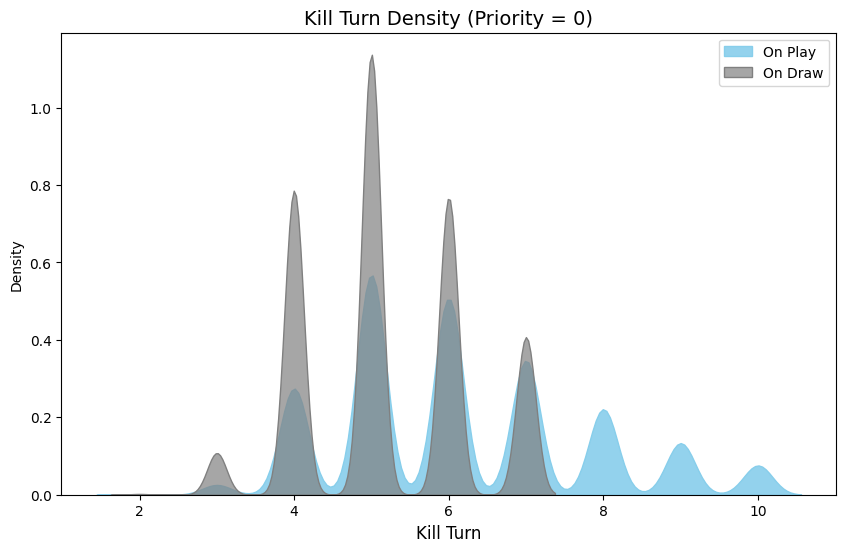

In [36]:
def plot_kde_play_vs_draw(priority):
    plt.figure(figsize=(10, 6))
    play_data = cleaned_data[(cleaned_data['start_label'] == 'On Play') &
                           (cleaned_data['removal_priority'] == priority)]['kill_turn']
    draw_data = cleaned_data[(cleaned_data['start_label'] == 'On Draw') &
                           (cleaned_data['removal_priority'] == priority)]['kill_turn']

    sns.kdeplot(play_data, label='On Play', color='skyblue', fill=True, alpha=0.9)
    sns.kdeplot(draw_data, label='On Draw', color='grey', fill=True, alpha=0.7)

    plt.title(f'Kill Turn Density (Priority = {priority})', fontsize=14)
    plt.xlabel('Kill Turn', fontsize=12)
    plt.legend()
    plt.show()

plot_kde_play_vs_draw(priority=0)

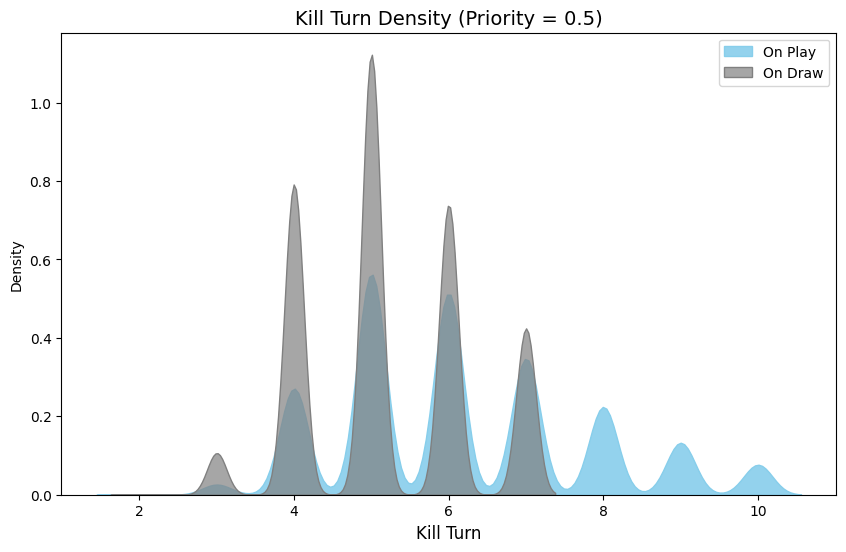

In [37]:
plot_kde_play_vs_draw(priority=0.5)

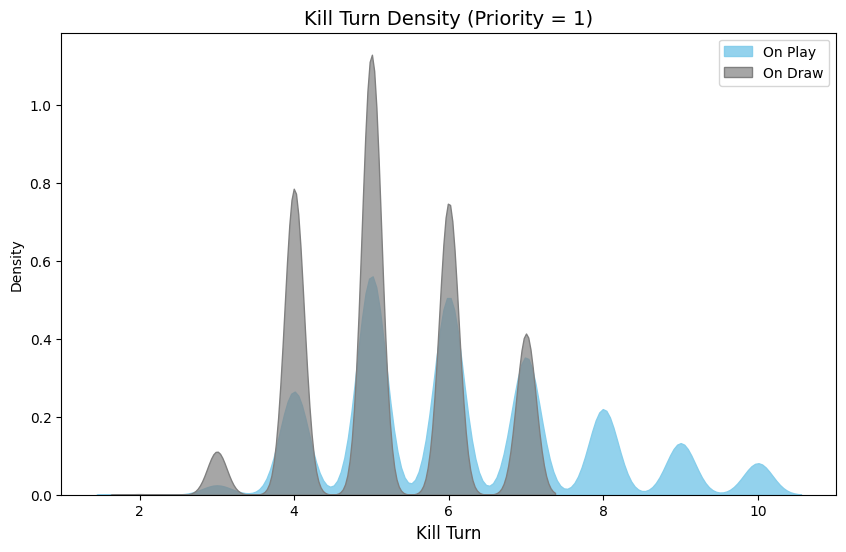

In [38]:
plot_kde_play_vs_draw(priority=1)

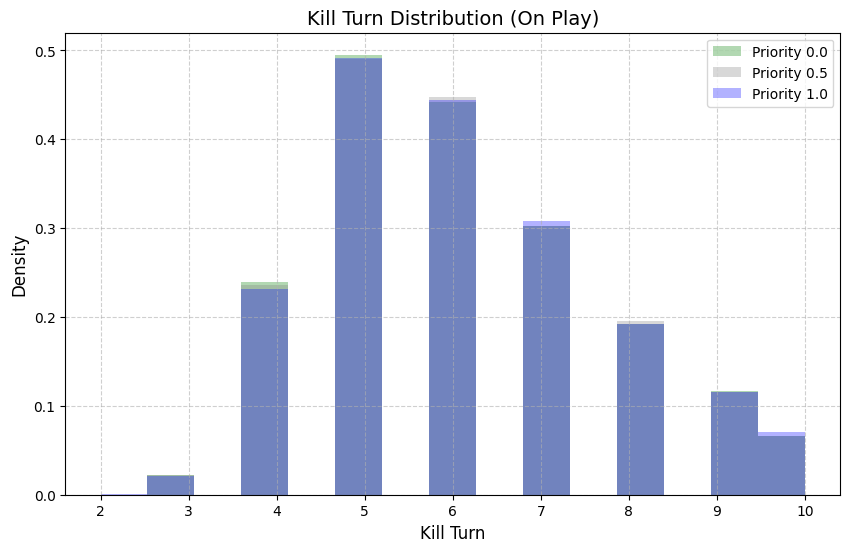

In [39]:
def plot_priorities(start_label):
    plt.figure(figsize=(10, 6))
    priorities = cleaned_data['removal_priority'].unique()
    colors = ['green', 'grey', 'blue']

    for priority, color in zip(priorities, colors):
        data = cleaned_data[(cleaned_data['start_label'] == start_label) &
                          (cleaned_data['removal_priority'] == priority)]['kill_turn']
        plt.hist(data, bins=15, alpha=0.3, label=f'Priority {priority}', color=color, density=True)

    plt.title(f'Kill Turn Distribution ({start_label})', fontsize=14)
    plt.xlabel('Kill Turn', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_priorities(start_label='On Play')

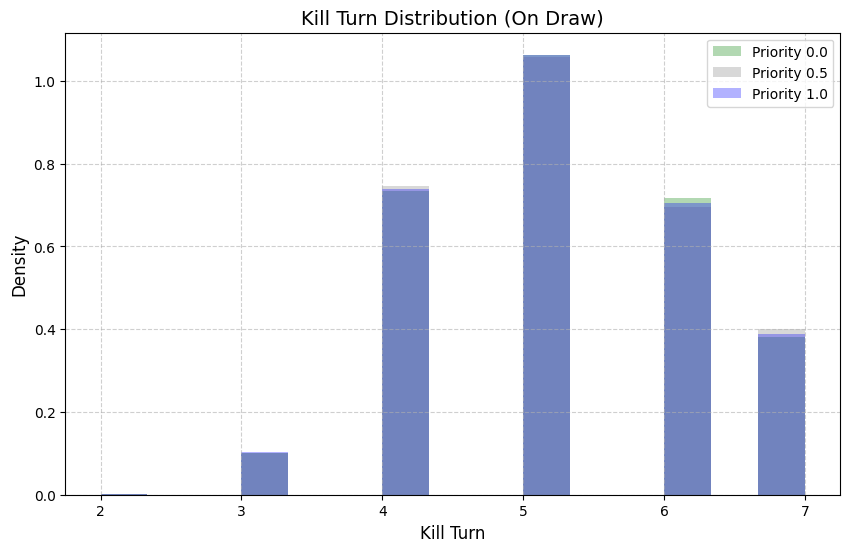

In [40]:
plot_priorities(start_label='On Draw')

# Analysis on statistical values

The differences in Mean between being on the play and draw for fixed removal priorities is as follows.

In [41]:
print(f"For no removal priority: Δmean = {stats["mean"]["On Play"][0.0] - stats["mean"]["On Draw"][0.0]:.3f}")
print(f"For some removal priority: Δmean = {stats["mean"]["On Play"][0.5] - stats["mean"]["On Draw"][0.5]:.3f}")
print(f"For full removal priority: Δmean = {stats["mean"]["On Play"][1.0] - stats["mean"]["On Draw"][1.0]:.3f}")

For no removal priority: Δmean = 0.960
For some removal priority: Δmean = 0.964
For full removal priority: Δmean = 0.985


The Mann-Whitney U test found this differences to be statistically significant. 

We could also consider the fact that the difference increases with the removal priority, but since it's not statistically significant from our previous tests, our hypothesis wouldn't have much support from data.

# "The Nuts!"

### Importing data

In [43]:
df_nuts=pd.read_csv("../data/low_kill_outliers.csv",sep=",")
df_nuts.head(3)

,start,kill_turn,actions,on_play,on_draw,removal_priority,start_label
0,On the draw!,3.0,['2 Lands in hand(\n [\'Pollute...,0,1,0.0,On Draw
1,On the draw!,3.0,['3 Lands in hand(\n [\'Field o...,0,1,0.0,On Draw
2,On the draw!,3.0,"[""3 Lands in hand(\n ['Island',...",0,1,0.0,On Draw


 Since the description of "The nuts" usually means the best hand possible and since the deck has the technical capacity to achieve a kill after out turn 2, we are mostly interested in seeing the hands and draws that happen on the play that involve a turn 2 kill and on the draw that involve a turn 3 kill. The latter one is done with an extra draw that might prove a significant edge, but still relevant.

### Treating data

In [44]:
data_t2 = df_nuts[
    (df_nuts['kill_turn'] == 2.0)]
print(f"Number of turn 2 kills: {data_t2.shape[0]}")
data_t2.head(10)

Number of turn 2 kills: 60


,start,kill_turn,actions,on_play,on_draw,removal_priority,start_label
16,On the draw!,2.0,"[""3 Lands in hand(\n ['Watery G...",0,1,0.0,On Draw
123,On the draw!,2.0,"[""2 Lands in hand(\n ['Fiel...",0,1,0.0,On Draw
142,On the draw!,2.0,"[""2 Lands in hand(\n ['Cephalid...",0,1,0.0,On Draw
156,On the draw!,2.0,"[""2 Lands in hand(\n ['Polluted...",0,1,0.0,On Draw
169,On the draw!,2.0,"[""2 Lands in hand(\n ['Flooded ...",0,1,0.0,On Draw
280,On the draw!,2.0,['3 Lands in hand(\n [\'Flooded...,0,1,0.0,On Draw
300,On the draw!,2.0,"[""2 Lands in hand(\n ['Swamp', ...",0,1,0.0,On Draw
384,On the draw!,2.0,"[""2 Lands in hand(\n ['Polluted...",0,1,0.0,On Draw
514,On the draw!,2.0,"[""2 Lands in hand(\n ['Oboro, P...",0,1,0.0,On Draw
541,On the draw!,2.0,"[""2 Lands in hand(\n ['Swamp', ...",0,1,0.0,On Draw


In [45]:
data_t3_draw = df_nuts[
    (df_nuts['kill_turn'] == 3.0) & (df_nuts['start_label'] == 'On Draw')]
print(f"Number of turn 3 kills on the draw: {data_t3_draw.shape[0]}")
data_t3_draw.head()

Number of turn 3 kills on the draw: 4347


,start,kill_turn,actions,on_play,on_draw,removal_priority,start_label
0,On the draw!,3.0,['2 Lands in hand(\n [\'Pollute...,0,1,0.0,On Draw
1,On the draw!,3.0,['3 Lands in hand(\n [\'Field o...,0,1,0.0,On Draw
2,On the draw!,3.0,"[""3 Lands in hand(\n ['Island',...",0,1,0.0,On Draw
3,On the draw!,3.0,"[""2 Lands in hand(\n ['Flooded ...",0,1,0.0,On Draw
4,On the draw!,3.0,"[""3 Lands in hand(\n ['Polluted...",0,1,0.0,On Draw


In [46]:
def extract_kept_hand_and_first_draw(action_text):
    kept_hand = []
    first_draw = None

    if not isinstance(action_text, str):
        return kept_hand, first_draw

    kept_hand_match = re.search(r"Kept hand with (\[.*?\])", action_text)
    if kept_hand_match:
        kept_hand_str = kept_hand_match.group(1)
        kept_hand = re.findall(r"[\"'](.+?)[\"']", kept_hand_str.replace(r"\'", "'"))

    actions = [a.strip().strip("'\"") for a in action_text.strip("[]").split("', '")]
    try:
        turn1_idx = actions.index('My turn 1.')
        for action in actions[turn1_idx:]:
            if action.startswith('Draw '):
                first_draw = action.replace('Draw ', '')
                break
    except ValueError:
        pass

    return kept_hand, first_draw

data_t2[['kept_hand', 'first_draw']] = data_t2['actions'].apply(lambda x: pd.Series(extract_kept_hand_and_first_draw(x)))

In [47]:
print("Most common kept cards:", Counter(data_t2['kept_hand'].explode()).most_common(7))
print("Most common first draws:", data_t2['first_draw'].value_counts().head())

Most common kept cards: [('Archive Trap', 128), (', ', 30), ('Polluted Delta', 18), ('Hedron Crab', 16), ('Watery Grave', 15), ('Flooded Strand', 15), ('Fractured Sanity', 15)]
Most common first draws: first_draw
Archive Trap.               27
Hedron Crab.                 6
Glimpse the Unthinkable.     6
Drown in the Loch.           3
Baleful Mastery.             2
Name: count, dtype: int64


Analyzing the most common kept cards and that is statistically considered the best draw, we can actually calculate optimal hands which could be considered "The nuts"

### Game Theory calculation of "The nuts"

Archive traps are an important part of this, in many respects 4 Archive traps with most combinations of turn 1 and 2 cards are wins, let's reverse engineer what a win looks like at the opponents turn 2 on the draw. 

First, let's try to find out if there is a possible win at turn 2 on the play despite not appearing in the simulation.
Let's suppose 4x Archive traps, these mill for 52 cards. Any hand against a deck that searches it's library on an early turn is a technical kill if we have 4x Archive traps in hand, and there isn't excessive mulligan by the opponent, and the alternative cost for the trap is available. 

Let's try scenarios for 3x Archive traps.
In essence, our turn 1 and 2 play need to replace the 13 cards milled by a forth Archive trap.
The only effective milling pieces in these turns are: Hedron Crab, Ruin Crab and Glimpse the Unthinkable.
Glipse by itself only mills 10, and so a Crab is needed. Glimpse taps out our mana in turn 2, therefore, a crab must be played on turn 1.
"The nuts" becomes: 3x Archive trap, 1x "Crab", 1x"Glimpse the Unthinkable", an untapped land on turn 1 for the "Crab" to be played and a second land on turn 2, also untapped. For good measure, a fetchland on turn 2 would increase the mill of that turn to 16 cards. The downside for this hand is also that the playpattern is susceptible to removal. Our "Crab" turn 1 play might face a removal spell, and the kill becomes impossible at turn 2. 

Further turns increase the fragility of this because the opponent is expected to have removal after his turn 2. A need for an almost non-interactable win for turn 3 starts appearing.
The best case scenario that does not involve "Crabs" at all is, 3x Archive trap, turn 1 can be used for any filler spell that might actually remove cards from the opponents' library, turn 2 Glimpse the Unthinkable since the opponent is still at 1 mana and possibly unable to respond effectively, and at turn 3 a cycled Fractured Sanity, given that it is an activated ability, it's extremely uncommon to be stopped while the opponent has 2 mana available.

On the draw it's a fight between playing these cards even on mana versus having one extra card draw to try to build the best hand. Which already depends on the interaction of the opponents' deck.

# Conclusions on the Statistic Analysis

### Does being on the draw make you faster in a race?

From a game theory perspective, being on the play should reduce the average kill turn by one—you get a full turn before your opponent. But there’s a hidden cost: in 1v1 Magic, the first player skips their draw step. That lost card matters.

In my simulation of 300,000 Modern Mill games, I found:

- Being on the draw actually reduced the average kill turn compared to being on the play.

- Variance also dropped—games on the draw ended more consistently around the same turn.

- The effect was robust across different removal priorities, which surprisingly had no statistically significant impact.

This runs counter to the conventional wisdom that “being on the play is always better.” That belief is mostly true in interactive matchups—playing lands and spells on curve first is critical for controlling the board. But in a pure race to a win condition, the extra card on the draw appears to outweigh the tempo advantage of the play.

In other words: if you’re racing, the draw gives you velocity and consistency. If you’re interacting, the play gives you tempo and control.

Further investigation is needed beyond removal priority. For instance, changing the decklist to include more or fewer removal spells, or to test the efficiency of mana and draw spells, could alter the results. Some builds replace Visions of Beyond with Preordain, since early game card selection often improves draw quality more than raw card quantity. Running these variations would help determine whether the advantage of being on the draw persists across different versions of the deck.